# Train a random-forest classifier

Let's see how a random forest can learn to distinguish misogynistic
speech from generic speech.

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV

*Know more about Sci-kit learn: https://scikit-learn.org/stable/*

### Load the data

In [3]:
df = pd.read_csv("../data/gold_data_en.csv")

In [4]:
df.shape

(16265, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16265 entries, 0 to 16264
Data columns (total 2 columns):
text     16265 non-null object
label    16265 non-null int64
dtypes: int64(1), object(1)
memory usage: 254.2+ KB


### Train-test split

It's important to split the data consistently
so that we keep a 50/50 ratio both in training and test.

In [6]:
df_train, df_test = train_test_split(
            df,
            train_size=.8,
            shuffle=True,
            stratify=df['label'].to_numpy(),
            random_state=42,
        )

In [7]:
df_train.shape, df_test.shape

((13012, 2), (3253, 2))

In [8]:
df_train.head()

,text,label
12166,http://t.co/ZxbZV39jru: Our fluffy cat loves b...,0
2677,'Oh so when a man sleeps with lots of women he...,1
6229,@GavGordonToGo @lllllinda @anniemac63 @NicolaS...,0
6974,I’m a not a whore.,0
10528,"@cisrabbit ""Loose"" was a Freudian reference...",1


Let's check the class balance:

In [9]:
df_train['label'].mean(), df_test['label'].mean()

(0.43175530279741775, 0.43160159852443897)

### Balance classes

To avoid bias (i.e. when an algorithm prefers one class to the other) we need to have an equal number of elements for each class.

In [10]:
df_train.groupby('label').count()

,text
label,
0,7394
1,5618


One can see here that we have a different number of elements for the two
classes.
Let's change that.
First let's count the elements of the minority class.

In [11]:
n_elements = min(df_train.groupby('label').count().to_numpy())[0]
n_elements

5618

Then sample an equal number from the two classes.

In [12]:
df_positive = df_train[df_train['label']==1].sample(n_elements, random_state=42)
df_positive.head()

,text,label
11114,@SfordUponAvon equal opportunity #sexsells #MKR,1
10666,RT @Spainballin44 @B_Diddy010 I'm not sexist b...,1
2277,@HillaryClinton Why don’t you crawl back in yo...,1
8714,STFU KAT YA BITCH! #MKR,1
9992,"RT @BigSmooth2 Not sexist, but females shouldn...",1


In [13]:
df_negative = df_train[df_train['label']==0].sample(n_elements, random_state=42)
df_negative.head()

,text,label
509,"Me too is about rape and sexual assault, way t...",0
4805,@IssaRae Lmao this bitch got no clue what shes...,0
13199,@Sir5000 @StormsOnSaturn no. something went aw...,0
16214,You don't suck Sheri and Emilie #DontLetTheBeh...,0
14436,"Kat, karma is going to kick you in the arse. #...",0


In [14]:
df_balanced = pd.concat((df_negative, df_positive)).reset_index(drop=True)
df_balanced

,text,label
0,"Me too is about rape and sexual assault, way t...",0
1,@IssaRae Lmao this bitch got no clue what shes...,0
2,@Sir5000 @StormsOnSaturn no. something went aw...,0
3,You don't suck Sheri and Emilie #DontLetTheBeh...,0
4,"Kat, karma is going to kick you in the arse. #...",0
5,"Any Bitch can start a war, it takes courage to...",0
6,@JessicaValenti Uh huh.\n\nLavinia Woodward ex...,0
7,who the fuck is calling my girl a whore and a ...,0
8,Let’s not let the hard won victories of the la...,0
9,Who is good at maths? What do they need to be ...,0


We store the balanced data in the original dataframe.

In [15]:
df = df_balanced

In [16]:
df['label'].mean()

0.5

### Load language model

Now let's create the Spacy NLP documents from our text data.

First we need to load the language model.

In [17]:
nlp = spacy.load("en_core_web_md")

In [18]:
# The .pipe() method batch processes all the text (will take a little while)
docs = list(nlp.pipe(df['text']))

### Vectors visualization

Here we take the document vectors from Spacy.

In [19]:
vector_matrix = np.array(list(map(lambda x: x.vector, docs)))

In [20]:
vector_matrix.shape

(11236, 300)

We use PCA to project the vectors to their principal components.

In [21]:
pca = PCA(2)

In [22]:
x_pca = pca.fit_transform(vector_matrix)

In [23]:
x_pca.shape

(11236, 2)

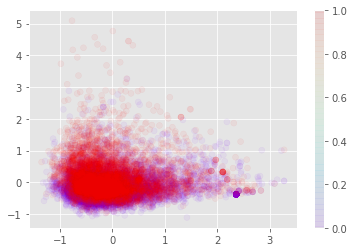

In [24]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['label'].tolist(), alpha=.05, cmap='rainbow');
plt.colorbar();

## Random forest classifier

The random forest algorithm is a pretty versatile one and generally
performs well.
Let's use the default parameters with just one change:
we'll use 100 trees.

In [25]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

<!-- ### Train-test split

It's important to split the data consistently
so that we keep a 50/50 ratio both in training and test. -->

In [26]:
# x_train, x_test, y_train, y_test = train_test_split(
#     vector_matrix,
#     df['label'].to_numpy(),
#     train_size=.8,
#     shuffle=True,
#     stratify=df['label'],
#     random_state=42,
# )

In [27]:
# x_train.shape

Let's check the class balance:

In [28]:
# y_train.mean(), y_test.mean()

And now we fit the model:

In [29]:
x_train = vector_matrix
y_train = df['label'].to_numpy()

In [30]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Let's try the fitted model on the test set:

In [31]:
x_test = np.array(list(map(lambda x: x.vector, nlp.pipe(df_test['text']))))

In [32]:
y_pred = rf.predict(x_test)

We can also extract probabilities.
The [1,0] prediction can always be recomputed
from the probabilities, knowing that the prediction is 1 when
the probability > 0.5 and 0 otherwise.

In [33]:
y_proba = rf.predict_proba(x_test)

There are several metrics to evaluate the performance of the model.
Common ones include the F1-score, the confusion matrix,
the ROC curve, and the area under the ROC curve (AUC).

In [34]:
y_test = df_test['label'].to_numpy()

In [35]:
f1_score(y_test, y_pred)

0.7045207956600361

Let's check what we get from the training data, just for fun:

In [36]:
f1_score(y_train, rf.predict(x_train))

0.9988424895378863

This is a very high value, which is expected since the training data has been used to train the model.

Let's look at what the prediction arrays look like.

In [37]:
y_pred

array([1, 1, 1, ..., 0, 0, 1])

In [38]:
y_proba

array([[0.17 , 0.83 ],
       [0.35 , 0.65 ],
       [0.36 , 0.64 ],
       ...,
       [0.65 , 0.35 ],
       [0.585, 0.415],
       [0.36 , 0.64 ]])

`y_proba` contains two columns, the first is the probability for class 0, the second is the probability
for class 1.

In [39]:
def plot_roc_auc_f1(y_test, y_proba, title=None):
    # This is a convenience function that takes care of boring stuff
    f1 = f1_score(y_test, y_proba[:, 1]>.5)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc_score = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    if title is not None:
        ax.set_title(title)
    ax.plot([0, 1], [0, 1], '--', label="Random")
    ax.plot(fpr, tpr, label="Your model")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.annotate(f"AUC: {auc_score:.4}", (.8, 0.05))
    ax.annotate(f"F1: {f1:.4}", (.8, 0.0))
    ax.legend()
    return f1, auc_score

### ROC curve

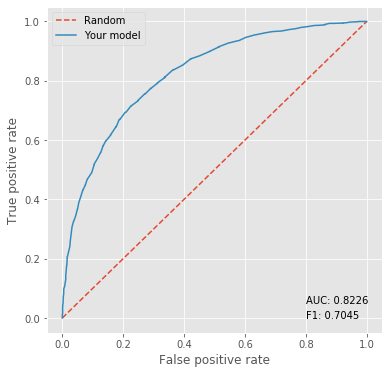

In [40]:
f1, auc_score = plot_roc_auc_f1(y_test, y_proba);

The straight line is equivalent to the performance of a random classifier.
The further away from it, the better.
The curve looks quite good and the given AUC is a decent value.

### F1-score, AUC

In [41]:
f1, auc_score

(0.7045207956600361, 0.8226358977440642)

The number of feature equals the length of the word vectors:

In [42]:
rf.n_features_

300

### A closer look at the predictions

In [43]:
# df_train, df_test = train_test_split(
#     df,
#     train_size=.8,
#     shuffle=True,
#     stratify=df['label'],
#     random_state=42,
# )

In [44]:
df_train.shape

(13012, 2)

In [45]:
df_test.shape

(3253, 2)

In [46]:
df_test['prediction'] = y_proba[:, 1]

Let's take a look at what the model predicts.

Misogynistic:

In [47]:
df_test[df_test['prediction']>.5].sort_values('prediction', ascending=False)['text'].tolist()

['@_rododo feminazi',
 '@DBTillman Skank',
 '@ArielBPaiva feminazi',
 '@LauraaSilveira feminazi',
 '@TylerIsAPerson whore',
 '@JNotValid Whore',
 '@Ocotcoizo feminazi',
 '@MissTwilight12 feminazi',
 'I liked a @YouTube video http://t.co/tr6tNfwd2f Male rights activist owns feminazi',
 '@bonesinsetember FEMINAZI',
 '... http://t.co/TXoM9j0E7V #asian #filipino #free #indian #japanese #oriental #thai #video #videos #vietnamese #whoriental #XXX',
 '@blackhairedtiny fucking whore',
 'I liked a @YouTube video from @uhohbrochannel http://t.co/DKbZw5Qy3W Feminazi FAIL',
 'Feminazi Blog Reminds Liberals Today Is “National Day of Appreciation for Abortion Providers”… http://t.co/HEpTZ3NsZL via @WeaselZippers',
 "RT @johnsarkiss I'm not sexist, but female comedians just aren't funny",
 "RT @pay_pay247 I'm not sexist, but women's basketball makes me want to puke",
 'RT @brassidio: #WholsMuhammad #UElkemdeCharlieHebdoDağıtılamaz http://t.co/eIFzg1hsJK',
 'RT @The_Loki_Jotunn: #FeminismIsAwful #Wome

Non-misogynistic:

In [48]:
df_test[df_test['prediction']<=.5].sort_values('prediction', ascending=False)['text'].tolist()

['@Boarhound the number of times lately I\'ve seen unironic use of "feminazi", "pc police", and for fucks sake "thought police" astounds me',
 'You should be humiliated Kat! You are awful!!! #MKR',
 "Drasko only likes his mum's hot pot, especially when she's drunk and unconscious #MKR",
 'Why does this stupid Herrera guy pass the ball without taking a touch then when he loses it presses like a cunt?',
 'And just when I thought it was over, they pull me back in!  #MKR #MKR2015',
 '@JTheJudge The thing is some men are shy and some women are more forceful like me: not all men are the out front protectors.',
 'RT @JordanWalker654 Lucky to come off that bus alive #womenbusdriverproblems #notsexist',
 'Is there enough blue in the wardrobe department!?\n#mkr',
 "RT @lwilliams0594 I'm not sexist, but this woman bus driver has nearly killed 2 pedestrians in the space of 4 minutes #sortitout",
 'If Cameroon got called for an ankle, THAT BITCH WAS DEF OFFSIDES.',
 'yeah colin would be looking for

### Visualization of probability distribution

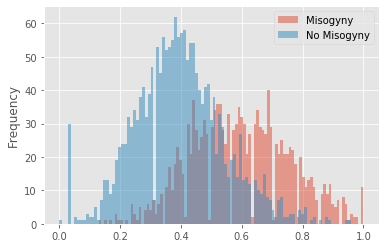

In [49]:
df_test['prediction'][df_test['label']==1].plot.hist(bins=99, alpha=.5, label="Misogyny")
df_test['prediction'][df_test['label']!=1].plot.hist(bins=99, alpha=.5, label="No Misogyny");
plt.legend();

## Parameter Optimization

One can fine-tune the model's hyperparameters in order to
find the best possible model.

In [50]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

In [51]:
# BEWARE: Searching for more than just a couple parameters will increase the calculation time exponentially!
param_grid = {
    "n_estimators": [50, 200],
#     "max_depth": [3, None],
#     "max_features": [1, 10, 100],
#     "min_samples_split": [10, 100, 1000],
#     "bootstrap": [True, False],
#     "criterion": ["gini", "entropy"],
}

In [52]:
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, iid=False, verbose=2, n_jobs=-1)

In [53]:
%%time
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.9s finished


CPU times: user 29.4 s, sys: 138 ms, total: 29.6 s
Wall time: 46.8 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=-1, param_grid={'n_estimators': [50

In [54]:
grid_search.cv_results_

{'mean_fit_time': array([ 6.00189438, 20.41637735]),
 'std_fit_time': array([0.06625505, 6.74117391]),
 'mean_score_time': array([0.11927028, 0.22210913]),
 'std_score_time': array([0.02566628, 0.03788422]),
 'param_n_estimators': masked_array(data=[50, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50}, {'n_estimators': 200}],
 'split0_test_score': array([0.72064057, 0.73176157]),
 'split1_test_score': array([0.74644128, 0.7566726 ]),
 'split2_test_score': array([0.72864769, 0.74688612]),
 'split3_test_score': array([0.73063224, 0.74220837]),
 'split4_test_score': array([0.71460374, 0.72573464]),
 'mean_test_score': array([0.7281931 , 0.74065266]),
 'std_test_score': array([0.01077834, 0.01095001]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [55]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
f1_score(y_test, grid_search.predict(x_test))

0.7133019209858644

In [57]:
y_proba = grid_search.predict_proba(x_test)

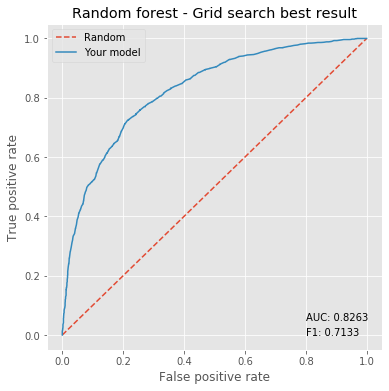

In [58]:
plot_roc_auc_f1(y_test, y_proba, title="Random forest - Grid search best result");

## Predict user input - A quick test

Remember: 0 is not misogynistic, 1 is misogynistic.

In [59]:
best_rf = grid_search.best_estimator_

In [60]:
misog_vector = nlp("Women are inferior to men.").vector

In [61]:
best_rf.predict_proba(misog_vector.reshape(1, -1))

array([[0.455, 0.545]])

In [62]:
best_rf.predict_proba(nlp("Have a nice day").vector.reshape(1, -1))

array([[0.585, 0.415]])

Seems to be working! :-)